# **ANALISE 001-VERSAO_NOVA**

# **Análise exploratória de dados - 001** 
# **ATENÇÃO ESTA É A CÓPIA MODIFICADA, ONDE EXCLUI TUDO O QUE FOI FEITO DIRETAMENTE NAS PLANILHAS, SERÁ AGORA A CÓPIA DE TRABALHO. SALVAR COM CUIDADO.**

.  
#### Vamos analisar a base de mobilidade do Google. Extraimos um relatório do site https://www.google.com/covid19/mobility/ na data 14/11/2021, contendo somente registros para o Brasil.  

Não faremos aqui uma modelagem estatística detalhada como feito por Basellini et al (2021) para a região da Inglaterra e Gales. Nosso modelo é mais simplificado e visual, e será complementado mais adiante por análises de séries temporais. O trabalho anteriormente citado e o de Bertagna (2021) tomam como linha de base o excesso de óbitos nas respectivas regiões estudadas, outro ponto que não entrará no escopo de nosso estudo. Porém diversos fatores considerados neste último serão também citados no nosso levantamento, cuja abrangência geográfica coincide em parte com a dele.

## Leitura e tratamento da primeira base de dados

In [ ]:
#imports necessários
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
%matplotlib inline
import pandas as pd
from datetime import datetime  
from datetime import timedelta
from datetime import time
from scipy.stats.stats import pearsonr

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")


#### Leitura do relatório de mobilidade do Google - Download do relatório de CSVs por região, 
do link https://www.google.com/covid19/mobility/, realizado no dia 14/11/2021. O arquivo é baixado em formato compactado (zip), que descompactado fornece os arquivos CSV para todos os países do mundo cobertos pelo relatório, para 2020 e 2021. Vamos copiar os arquivos do Brasil para 2020 e 2021 e fazer sua leitura. 

ATENÇÃO - Aqui são descritos os passos feitos diretamente no excel na planilha alvo mencionada abaixo. Para cada etapa feita no excel, a célula de código python correspondente será excluida, para manter mais claras e coerentes as etapas. Antes disso tudo começar, farei uma cópia backup deste notebook, com o nome de : ANALISE 001 - Bases de mobilidade Google - estado de SP, por cidades e consolidado - BACKUP.ipynb

#### ATENCAO PARA JUNTAR OS ANOS 2020 E 2021 E PROCEDER A TODOS OS PASSOS ABAIXO NOVAMENTE, RODAR NO WINDOWS DEVIDO AO PROBLEMA NO MAC OS  MONTEREY QUE ESTÁ AFETANDO O EXCEL.  

1. Salvar os arquivos origem em formato EXCEL, após fazer a separação das colunas. Isso deixa os originais CSV como backup.    
2. Baixar os arquivos para 2020 e 2021.
3. Juntar os dois arquivos num único.
4. Excluir as colunas que não serão utilizadas: country_region_code e country_region (pois o arquivo só contém um país, o Brasil), metro_area,iso_3166_2_code,census_fips_code,place_id (não serão utilizadas). 
5. Preencher os vazios da primeira coluna com CONSOLIDADO BRASIL (números consolidados do país) e manter apenas essas linhas mais as do estado de São Paulo
6. Preencher os vazios da segunda coluna com CONSOLIDADO SAO PAULO (números consolidados do estado).  
7. Mudar State of Sao Paulo para SAO PAULO
8. TRATAMENTO DE ACENTUAÇÃO: vamos padronizar as duas primeiras colunas SEM CARACTERES ACENTUADOS E EM MAIÚSCULAS. Este trabalho rende mais manualmente. Inclui alguns acertos manuais como mudar "d'oeste" para "doeste" para evitar problemas futuros de sintaxe. 
9. Renomear colunas, todas em português.
10. A base será acessada mais adiante após o tratamento da segunda base



## Leitura e tratamento da segunda base de dados

Leitura do arquivo de casos para o Estado de São Paulo, obtido a partir do repositório de dados do SEADE (Fundação Sistema Estadual de Análise de Dados - Governo de São Paulo), em : https://github.com/seade-R/dados-covid-sp.  
ATENÇÃO: da mesma forma como feito acima com os dados do Google, realizamos o pré-processamento diretamente no arquivo lido, via Microsoft Excel : caracteres acentuados foram substituídos manualmente, nome do município em maiúsculas, e todas as colunas desnecessárias foram retiradas, ficando somente as que utilizaremos no momento : municipio, data, casos e óbitos registrados na data. Em próximas análises, quando novamente fizermos o download do arquivo, eventualmente aproveitaremos outras colunas. Portanto este arquivo tem o sufixo "modif", pois foi modificado previamente a esta análise. 

In [ ]:
dados_sp = pd.read_excel('dados_covid_sp_modif.xlsx')

Sendo o tempo médio de incubação do coronavirus (infecção até primeiros sintomas) de 5 dias (conforme https://portal.fiocruz.br/pergunta/qual-e-o-tempo-de-incubacao-do-novo-coronavirus), vamos inicialmente criar uma coluna para a data de infecção mais provável. Já fica no formato de data padrão para seguir a outra base (aaaa-mm-dd)

In [ ]:
from datetime import timedelta 
from datetime import datetime

tempo_medio_incub_dias = 10

lista = []

for dt in dados_sp['data']:
    dti = datetime.strptime(str(dt), '%Y-%m-%d %H:%M:%S')
    dti = dti - timedelta(days = tempo_medio_incub_dias)
    lista.append(dti.strftime('%Y-%m-%d'))
    
dados_sp['datainf_prov'] = lista   

In [ ]:
#vamos excluir dessa base as colunas que não precisaremos no momento: datahora (original) e 
#obitos_novos (olharemos apenas para os casos da doença)
dados_sp = dados_sp.drop(columns=['data','obitos_novos'])

In [ ]:
#vamos padronizar os nomes dos campos de municipio e data inf para bater com a base de mobilidade
#dados_sp
dados_sp.columns = ['municipio','casos_novos','data']

ATENÇÃO, nao faremos mais aqui o deslocamento das datas e criação de uma nova coluna deslocada 15 dias. Isso será feito no gráfico de linhas e de forma parametrizada. 

Vamos criar uma cópia da base acima consolidada por data, sem as cidades, para conter a visao geral do estado e em seguida juntar a tabela acima.

In [ ]:
dados_sp_consolidado = dados_sp.groupby(['data']).sum()
dados_sp_consolidado['municipio'] = "00 CONSOLIDADO SAO PAULO"

In [ ]:
dados_sp_consolidado=dados_sp_consolidado.reset_index()

In [ ]:
dados_sp_consolidado['casos_novos1'] = dados_sp_consolidado['casos_novos']
dados_sp_consolidado['data1'] = dados_sp_consolidado['data']
dados_sp_consolidado = dados_sp_consolidado.drop(columns=['casos_novos','data'])
dados_sp_consolidado.columns = ['municipio','casos_novos','data']

In [ ]:
#junta a base detalhe com a base agrupada
dados_sp = pd.concat([dados_sp,dados_sp_consolidado])

Agora vamos criar uma nova base de dados que seja a junção da primeira com a segunda, utilizando como campos de amarração o nome do municipio e a data provavel de infeccao. Vamos adicionar a coluna casos_novos à primeira base. Antes temos que ler a primeira base, que foi formatada diretamente no excel.

In [ ]:
dados_mob_sp = pd.read_excel("BR_Region_Mobility_Report.xlsx")

### JOIN das bases

In [ ]:
dados_mob_casos_sp = pd.merge(dados_mob_sp, dados_sp, on=["municipio","data"], how="inner")

Temos agora, então, nossa base de trabalho, a partir da qual vamos realizar nossa análise propriamente dita. 

### Análise exploratória 001A - Plotagem fixando cidade, mostrando evolução por data x média das variações de mobilidade x casos registrados na data

In [ ]:
#verificar valores ausentes nas colunas
dados_mob_casos_sp.isna().sum()

problema: há muitos valores ausentes nas colunas, por causa das falhas de medição das 
variações de mobilidade. Vamos preencher esses vazios utilizando a técnica **MISS FOREST** 
(preenchimento através de **random forest**)[RADECIC,2020]. A célula abaixo pode demorar para rodar, devido às iterações do modelo.

In [ ]:
import sklearn.neighbors._base
import sys

sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest


imputer = MissForest()

X = dados_mob_casos_sp[['comercio_recreacao','alimentacao_farmacia',
                        'parques','estacoes_transporte','locais_trabalho','residencias']]

X_imputed = imputer.fit_transform(X)

dados_mob_casos_sp[['comercio_recreacao','alimentacao_farmacia',
                     'parques','estacoes_transporte','locais_trabalho','residencias']] = X_imputed

In [ ]:
#verificando novemente - não há mais nulos!!!
dados_mob_casos_sp.isna().sum()

In [ ]:
#acrescentar a coluna com a média das variaçoes de mobilidade
dados_mob_casos_sp['med_var_mob'] =  (dados_mob_casos_sp['comercio_recreacao'] +
                                     dados_mob_casos_sp['alimentacao_farmacia'] +
                                     dados_mob_casos_sp['parques'] +
                                     dados_mob_casos_sp['estacoes_transporte'] +
                                     dados_mob_casos_sp['locais_trabalho'] +
                                     dados_mob_casos_sp['residencias']) / 6

In [ ]:
#acresccentar a coluna com a média móvel (7 dias) para os casos novos e outra para a mobilidade. 
#Veremos mais dessa média nos cálculos envolvendo tempo
dados_mob_casos_sp['MMS7-casos'] = dados_mob_casos_sp['casos_novos'].rolling(window=7).mean()
dados_mob_casos_sp['MMS7-mob']   = dados_mob_casos_sp['med_var_mob'].rolling(window=7).mean()

In [ ]:
#limpeza dos ultimos valores nulos, sempre usando o método 
#verificar valores ausentes nas colunas
dados_mob_casos_sp.isna().sum()

Neste momento em especial, os pontos com valores nulos são os 6 iniciais, podendo causar distorção no início das curvas. Será melhor, portanto, exclui-los ao invés de substituir, fosse qual fosse o método de substituição.

In [ ]:
dados_mob_casos_sp = dados_mob_casos_sp.dropna()

In [ ]:
dados_mob_casos_sp.isna().sum()

In [ ]:
#ainda há valores distorcidos no início, vamos considerar somente os dados a partir de 01/04/20
dados_mob_casos_sp = dados_mob_casos_sp[dados_mob_casos_sp['data'] > '2020-03-31']

In [ ]:
#padroniza as colunas de valores
from sklearn.preprocessing import MinMaxScaler

def padroniza_scaler(df,cols):
    scaler = MinMaxScaler()
    scaler.fit(df[cols])
    return(scaler.transform(df[cols]))

#utilizar este
def normaliza_minmax(df,cols):
    for x in df[cols]:
        df[x] = (df[x] - df[x].min()) / (df[x].max() - df[x].min())
    return(df[cols])

In [ ]:
def filtroMunicipio(df,m):
    filtro_munic =(df['municipio'] == m)
    dados_munic = df[filtro_munic]
    return(dados_munic)

In [ ]:
def filtroDataFinal(df,d):
    filtro_data = (df['data'] <= d)
    dados_data = df[filtro_data]
    return(dados_data)

#### **Colocar os mapas abaixo depois dos gráficos de linhas e de correlações**

Abaixo, os mapas gerados na ferramenta Tableau, comparando a mobilidade em 30/05/21 e o número de casos a partir de 31/05/21. A distribuição da mobilidade e dos casos ao longo das mais importantes rodovias do estado, como podemos ver nos mapas, confirma o ponto levantado por Miguel Nicolelis (NICOLELIS et al, 2021) do importante papel das redes de estradas brasileiras como vias através das quais a COVID-19 espalhou-se dos grandes centros para o interior - e depois, via "efeito bumerangue", houve o fluxo de doentes em sentido contrário, em busca de tratamento adequado em cidades de maior porte. 

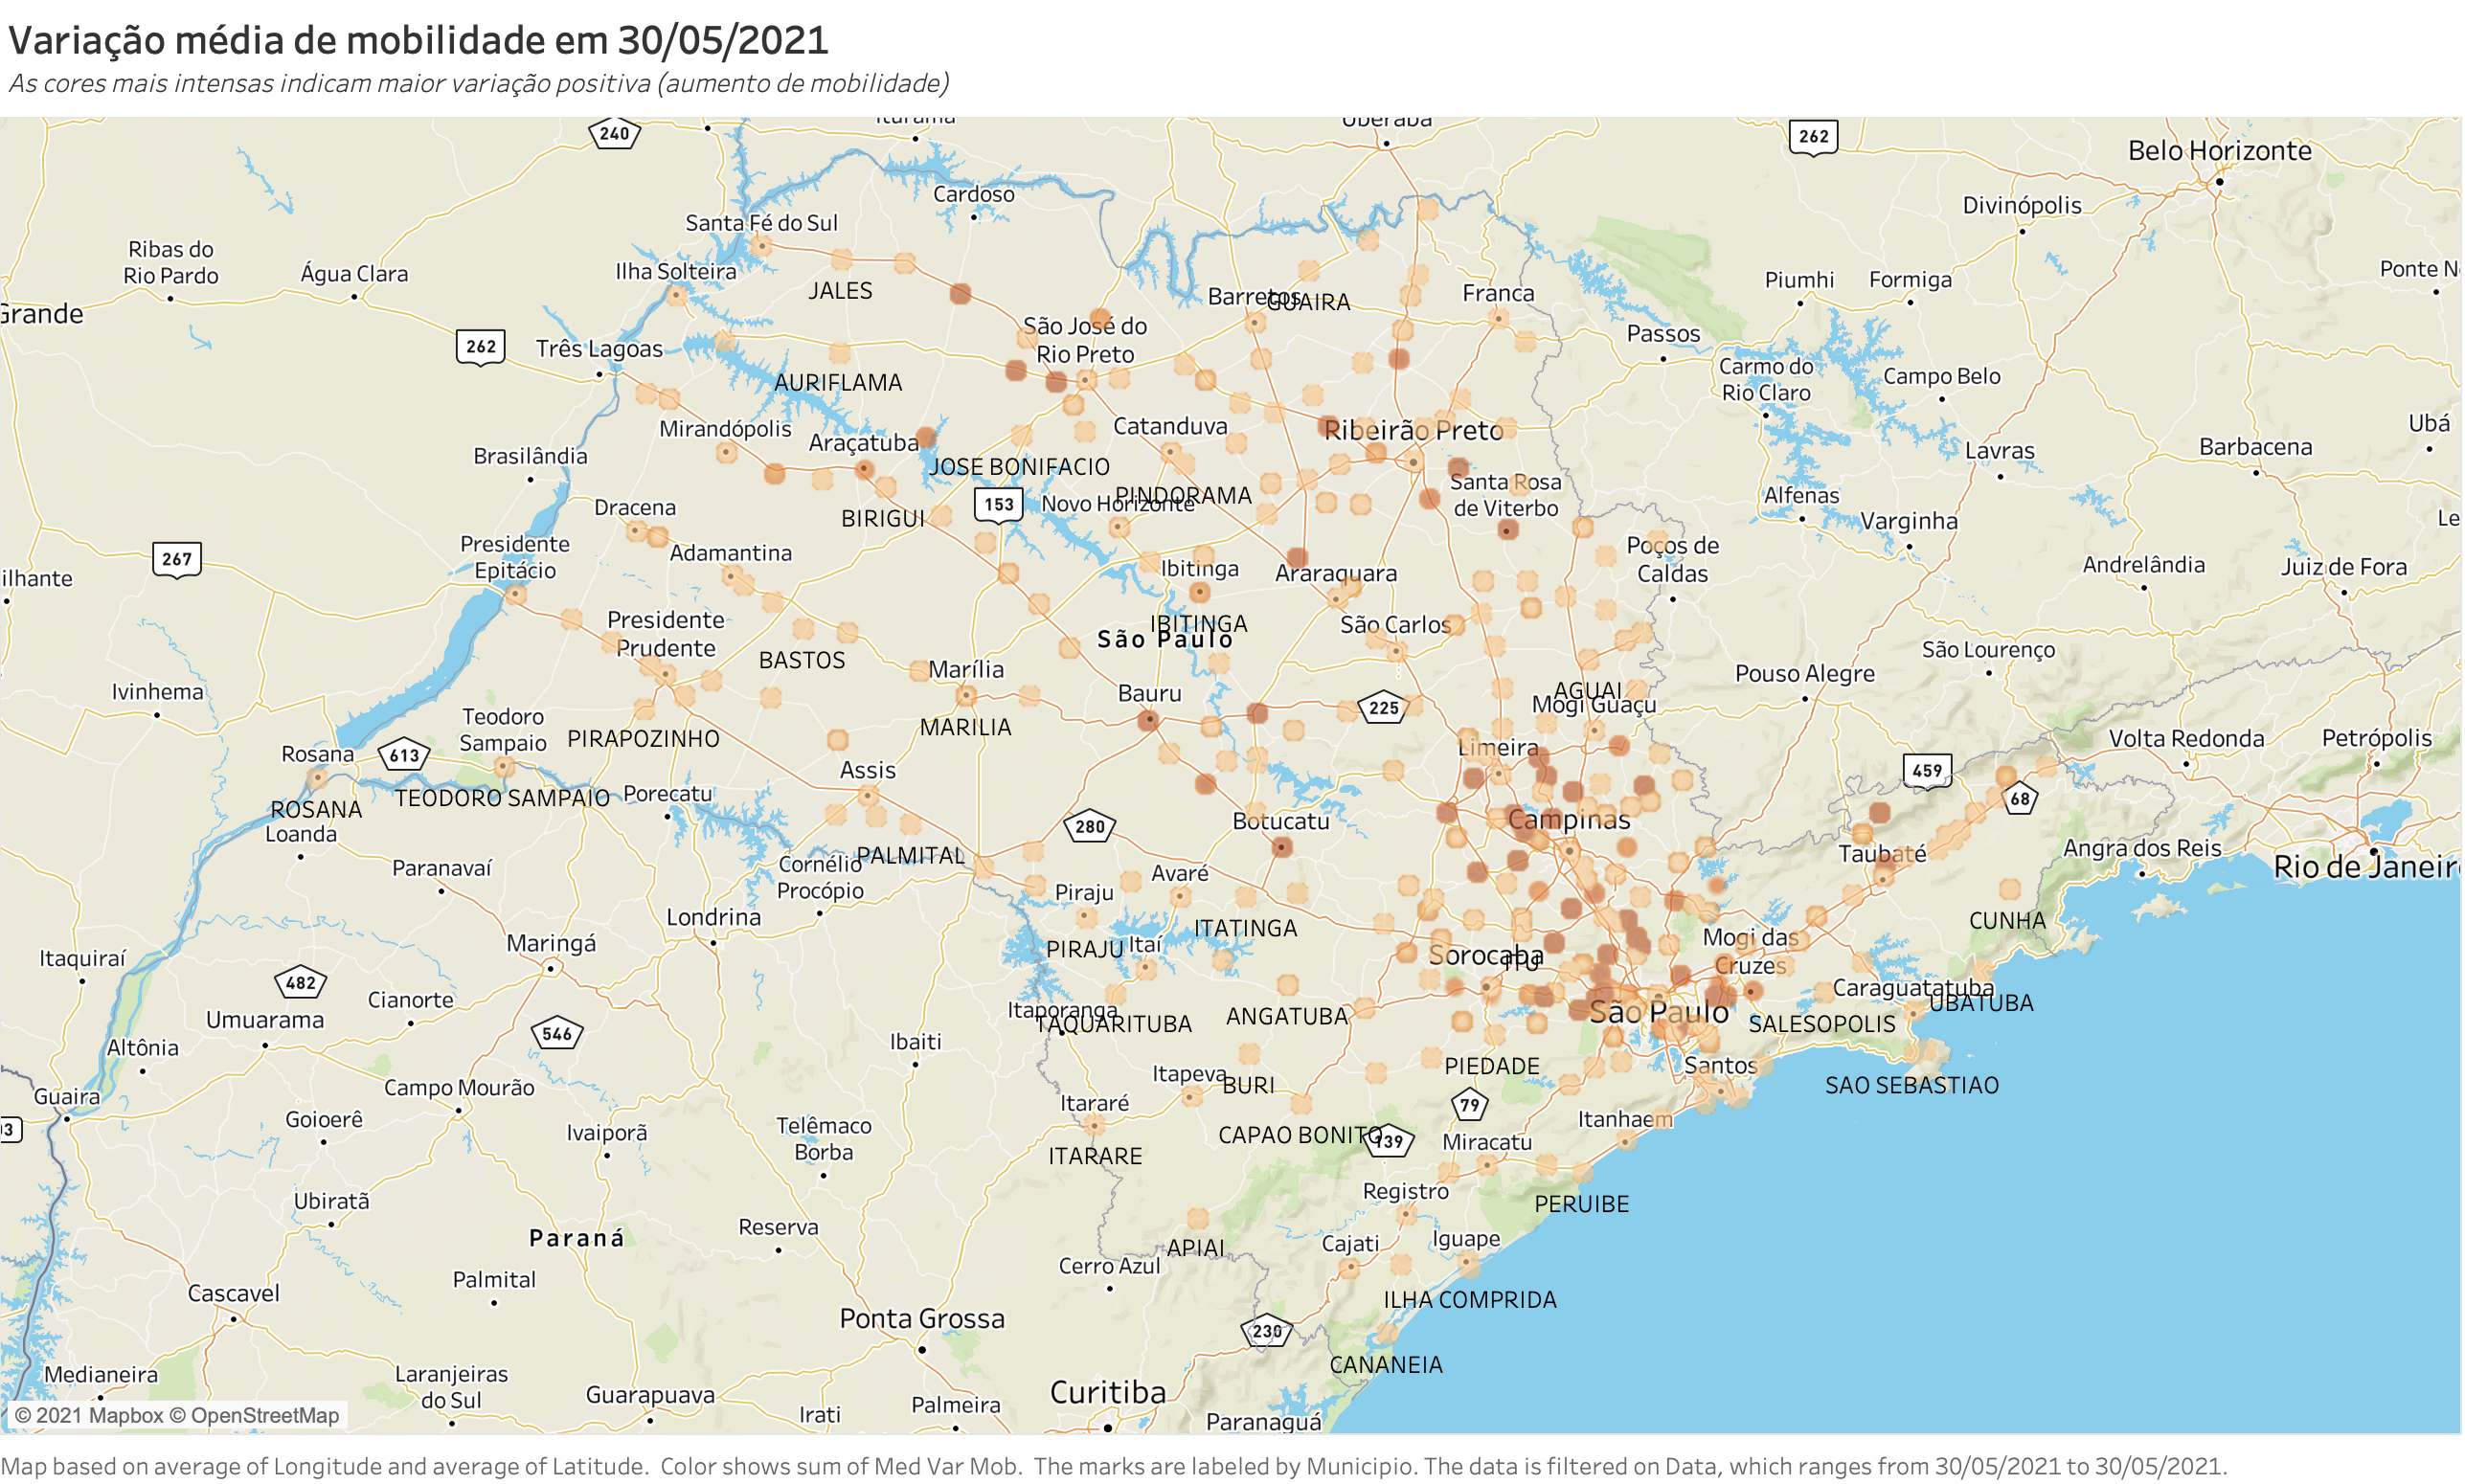

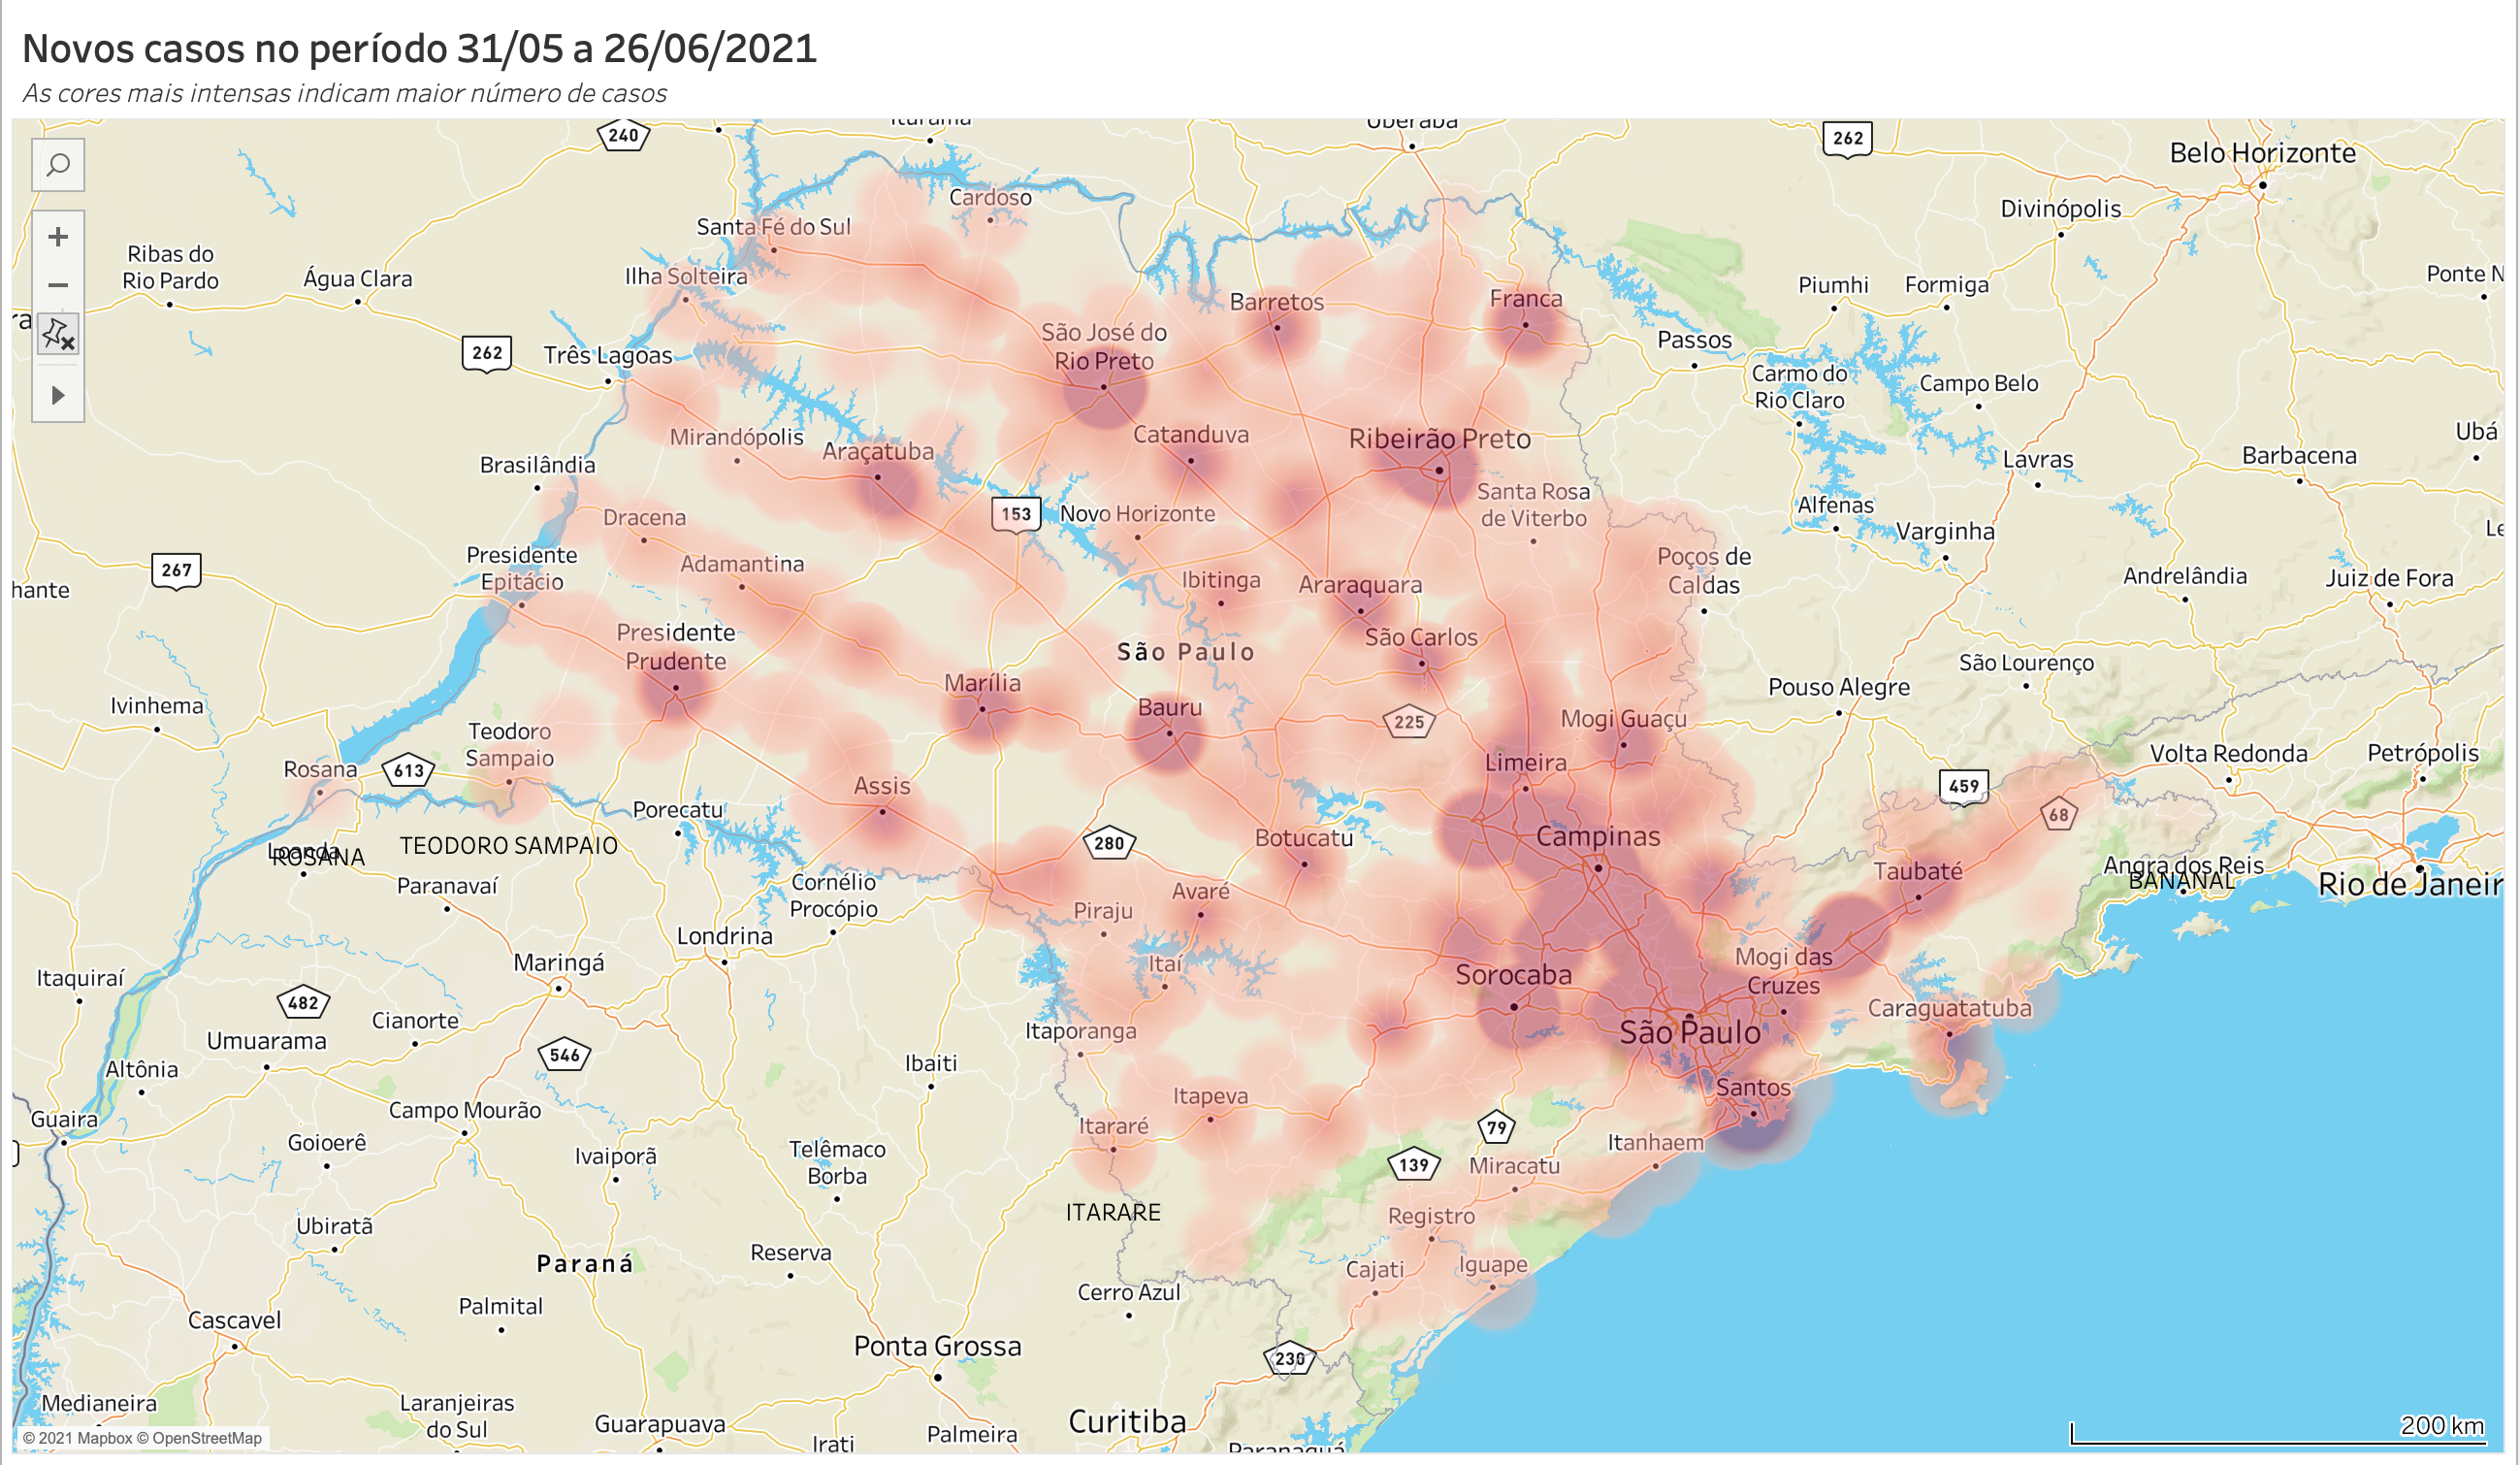

## **Estudo da correlação linear entre a evolução dos casos e da variação de mobilidade no tempo - apoio para a geração dos gráficos**

In [ ]:
colunas = ['comercio_recreacao','alimentacao_farmacia','parques','estacoes_transporte',
           'locais_trabalho','residencias','casos_novos']

In [ ]:
#aqui normalizamos as colunas da base. Quando houve a normalização na hora dos gráficos de 
#linhas foi com uma variável interna.
dados_mob_casos_sp[colunas] = normaliza_minmax(dados_mob_casos_sp,colunas)

In [ ]:
#para analisar no tempo, temos que fixar o local. Fixemos inicialmente município = SAO PAULO
def dados_munic(munic):
    filtro_munic =(dados_mob_casos_sp['municipio'] == munic)
    dados = dados_mob_casos_sp[filtro_munic]
    return(dados)

In [ ]:
df = dados_munic("SAO PAULO")

In [ ]:
df = df[colunas] #mantem apenas as colunas que devem entrar na correlação

In [ ]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
corr = df.corr()['casos_novos']
corr[:-1]

In [ ]:
def correlacao_maxima(munic):
    
    df = dados_munic(munic)
    df = df[colunas] #mantem apenas as colunas que devem entrar na correlação
    rs = np.random.RandomState(0)
    corr = df.corr()['casos_novos'] #obtem a correlação de cada categoria com casos novos
    cat = corr[:-1].max() #retorna o valor da maior correlação positiva
    return(cat)

In [ ]:
def categoria_correlacao_maxima(munic):
    
    df = dados_munic(munic)
    df = df[colunas] #mantem apenas as colunas que devem entrar na correlação
    rs = np.random.RandomState(0)
    corr = df.corr()['casos_novos'] #obtem a correlação de cada categoria com casos novos
    ind = corr[:-1].argmax() #retorna o nome da categoria de maior correlação positiva
    return(colunas[ind])
    

In [ ]:
categoria_correlacao_maxima("SAO PAULO")

In [ ]:
correlacao_maxima("SAO PAULO")

In [ ]:
categoria_correlacao_maxima("ARARAQUARA")

In [ ]:
correlacao_maxima("ARARAQUARA")

In [ ]:
categoria_correlacao_maxima("ITU")

In [ ]:
correlacao_maxima("ITU")

In [ ]:
categoria_correlacao_maxima("BOTUCATU")

In [ ]:
correlacao_maxima("BOTUCATU")

In [ ]:
#cravar a data final
dados_mob_casos_sp = filtroDataFinal(dados_mob_casos_sp,'2021-06-30')

### **ATENÇÃO - a célula abaixo leva aproximadamente uma hora para rodar. Se não houver necessidade de reprocessar tudo, carregar o arquivo que é gravado logo abaixo para poder pular e prosseguir.**

In [ ]:
import time

#ATENCAO ESTA CELULA DEMORA BASTANTE PARA PROCESSAR - - pouco mais de uma hora
ini = time.time() 
lista_cat = []
lista_corr = []
perc = 0
total_linhas = dados_mob_casos_sp.shape[0]
for m in dados_mob_casos_sp['municipio']:
    lista_cat.append(categoria_correlacao_maxima(m))
    lista_corr.append(correlacao_maxima(m))
    perc += (1/total_linhas)*100
    print('*** processado ',perc,'%')
    
dados_mob_casos_sp['CAT_MOB_PRINCIPAL'] = lista_cat
dados_mob_casos_sp['CORR_CAT_MOB_PRINCIPAL'] = lista_corr    
fim = time.time()   
print("********* processou em ",fim-ini," segundos")
   

In [ ]:
#salvar a versão da base acima em excel --- assim se precisar rodar as células abaixo 
#quando não houve alteração acima, é só rodar a célula seguinte, da carga.
dados_mob_casos_sp.to_excel("dados_mob_casos_sp_correlacao.xlsx")

In [ ]:
#carga do arquivo - VIR DIRETO PARA CÁ caso não precise reprocessar nada acima
dados_mob_casos_sp = pd.read_excel("dados_mob_casos_sp_correlacao.xlsx")

As duas visualizações abaixo foram geradas no TABLEAU a partir da tabela acima, e são equivalentes. Cada categoria de variação de mobilidade é representada por uma cor, e no caso da primeira visualização (em círculos) cada ponto é uma linha da tabela (com tamanho proporcional ao valor da correlação principal).



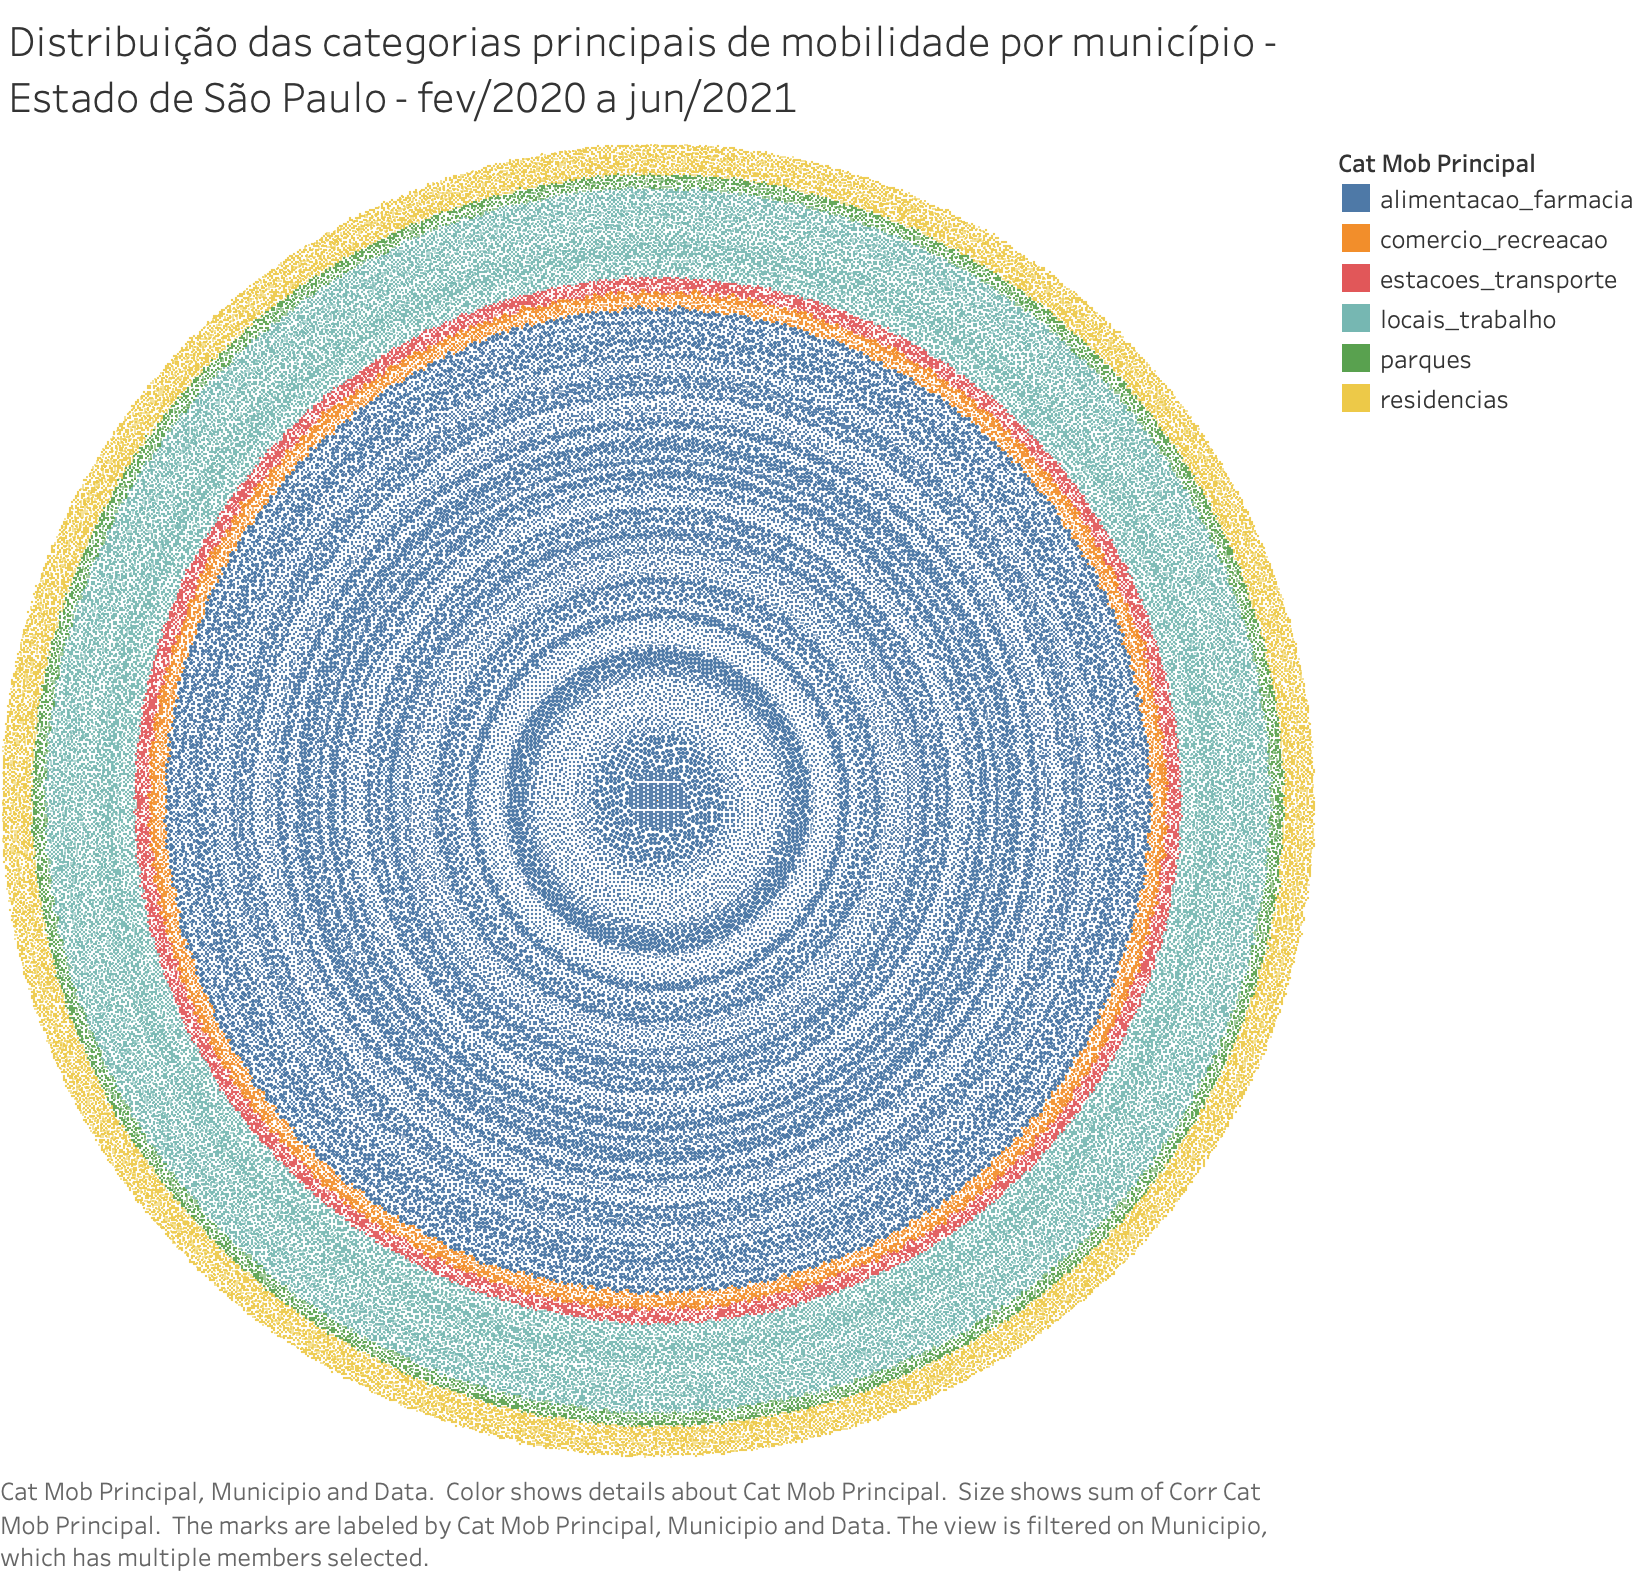




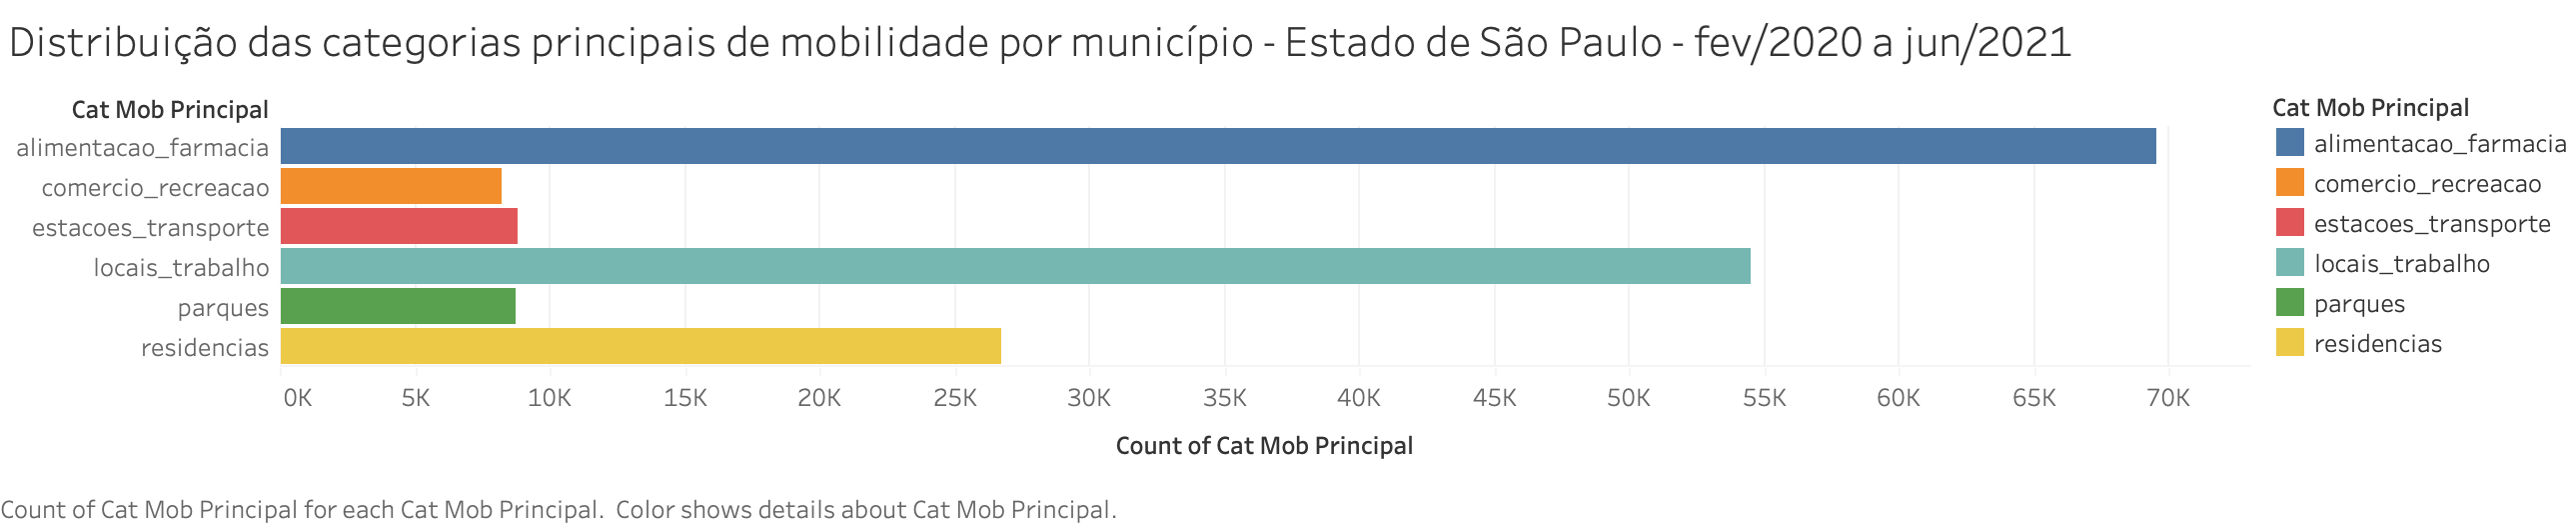








Qual seria, segundo tais critérios, a maior de todas as correlações no estado de SP, e qual a categoria e cidade?

In [ ]:
dados_mob_casos_sp['CORR_CAT_MOB_PRINCIPAL'].max()

In [ ]:
dados_mob_casos_sp[dados_mob_casos_sp['CORR_CAT_MOB_PRINCIPAL'] == dados_mob_casos_sp['CORR_CAT_MOB_PRINCIPAL'].max()][['municipio','CAT_MOB_PRINCIPAL']]

Temos então uma correlação máxima de 0.4739 entre a categoria ALIMENTAÇÃO FARMÁCIA e o número de novos casos, para o município de CAMPOS DO JORDAO. 

## **Análise exploratória 001A - Plotagem fixando cidade, mostrando evolução por data x média das variações de mobilidade x casos registrados na data**

#### agora vamos gerar a segunda versão do gráfico de linhas

In [ ]:
def deslocaDatas(df,shift):
    datas = []
    for d in df:
        d = datetime.strptime(d, "%Y-%m-%d")
        d = d - timedelta(days=shift)
        datas.append(d.strftime("%Y-%m-%d"))
    df = datas
    return(df)

In [ ]:
def datasToInt(s):
    serieInt = []
    i = 0
    for d in s:
        serieInt.append(i)
        i += 1
        
    return(serieInt)    
        

In [ ]:
lockdown_sp = pd.read_excel("lockdown_sp.xlsx")
dados_mob_casos_sp_lockdown = pd.merge(dados_mob_casos_sp,lockdown_sp,on=['municipio','data'],how='left')

In [ ]:
#exclui a primeira coluna e a última, não serão utilizadas
dados_mob_casos_sp_lockdown = dados_mob_casos_sp_lockdown.drop(['Unnamed: 0', 'fonte'], axis=1)

In [ ]:
dados_mob_casos_sp_lockdown.fillna('')

In [ ]:
def isNaN(num):
    return num != num

In [ ]:
def plotMunicipioLockdown(m, shift=0):
    
    # Filtra o município
    serie = filtroMunicipio(dados_mob_casos_sp_lockdown, m) 
    
    # Filtra a data --- aqui vamos pegar até o meio de 2021
    serie = filtroDataFinal(serie,'2021-06-30')
    
    linha = "*"* 126
    print(linha)
    print("ANÁLISE DE MOBILIDADE (RELATÓRIO GOOGLE) X NOVOS CASOS DE INFECÇÃO POR COVID - 19 (BASE SEADE-SP) NO ESTADO DE SÃO PAULO, PARA O MUNICÍPIO DE ",m, "- período de",serie['data'].min(),"a", serie['data'].max())
    print(linha)
    
    # Normaliza os dados 
    colunas_tratadas = ['MMS7-casos','MMS7-mob']
    serie[colunas_tratadas] = normaliza_minmax(serie,colunas_tratadas)
    
    #----- DESENHA O GRÁFICO DE LINHAS --------------------------------------------------------
    
    # se o parametro shift for diferente de zero, criar uma coluna adicional de data para a
    # plotagem da curva de casos deslocada
    
    if shift == 0:
        serie['data_shift'] = serie['data']
    else:
        serie['data_shift'] = deslocaDatas(serie['data'], shift)
        
    
    fig = plt.figure(figsize=(35,15))
    
    #linha variação média móvel mobilidade
    plt.plot(serie['data'], serie['MMS7-mob'], color = 'blue', label = 'MM7 MOBILIDADE',linewidth=7)

    #linha variação média móvel casos
    plt.plot(serie['data_shift'], serie['MMS7-casos'],color = 'red', label = 'MM7 CASOS',linewidth=7)
    
    #traça as linhas de lockdown
    plt.bar(serie['data'],serie['evento'],
            width=2, color='green',label='início lockdown',linestyle=':')
    
    plt.legend(loc=4,fontsize='xx-large')
    plt.title("EVOLUÇÃO NO TEMPO DE MOBILIDADE X NOVOS CASOS (deslocados em " + str(shift) + "dias) PARA "+ m,fontsize='xx-large')
    
    #formata datas no eixo horizontal
    serie_eixo = list(serie['data'])
    for i in range(len(serie_eixo)):
        if (i % 10) != 0:
            serie_eixo[i] = ''
    plt.xticks(rotation=90)    
    plt.xticks(size=20)
    plt.xticks(serie_eixo)
    
    plt.show()
    
    #----- CALCULA A CORRELAÇÃO ---------------------------------------------------------------
    
    mob_col = serie['MMS7-mob'].values
    casos_col = serie['MMS7-casos'].values
    corr , _ = pearsonr(mob_col, casos_col)
    
    linha = "-"* 127
    print(linha)
    print("CORRELAÇÃO LINEAR ENTRE AS MÉDIAS MÓVEIS DE VARIAÇÃO DE MOBILIDADE E DE CASOS NOVOS PARA",
          m, "\nPeríodo de",serie['data'].min(),"a", serie['data'].max(),":",corr)
    print(linha)
    
    #----- DESENHA O PLOT DE CORRELAÇÃO -------------------------------------------------------
    
    print("\n\n>>> A escala de cores do gráfico corresponde ao tempo (valores maiores == datas mais recentes) <<<\n\n")
    categ = serie['CAT_MOB_PRINCIPAL'].unique()
    
    fig = plt.figure(figsize=(35,15))
    plt.xlabel("MMS7 MOBILIDADE",fontsize='xx-large')
    plt.ylabel("MMS7 CASOS",fontsize='xx-large')
    plt.scatter(serie['MMS7-mob'], serie['MMS7-casos'],
                s=2500,alpha=0.5,edgecolors='face', c=datasToInt(serie['data']))
    plt.title("CORRELAÇÃO VARIAÇÃO DE MOBILIDADE X NOVOS CASOS PARA " 
              + m + " (categoria principal de mobilidade : "+ categ + ")",fontsize='xx-large')
    
    z = np.polyfit(serie['MMS7-mob'], serie['MMS7-casos'], 1)
    p = np.poly1d(z)
    plt.plot(serie['MMS7-mob'],p(serie['MMS7-mob']),"r:",linewidth=8)
    plt.colorbar() 
    plt.show()
    
    return

## **Os gráficos a seguir deverão ir para a seção de resultados do texto final de nosso trabalho.**

#### Capital do estado e cidades com alto crescimento no número de casos

In [ ]:
plotMunicipioLockdown('BOTUCATU')

In [ ]:
plotMunicipioLockdown('BARRETOS')

In [ ]:
plotMunicipioLockdown('SAO PAULO',-30)

In [ ]:
plotMunicipioLockdown('SAO CARLOS')

In [ ]:
plotMunicipioLockdown('PAULINIA')

In [ ]:
plotMunicipioLockdown('PRAIA GRANDE')

In [ ]:
plotMunicipioLockdown('PENAPOLIS')

In [ ]:
plotMunicipioLockdown('FRANCISCO MORATO')

#### Cidades com baixo crescimento de casos (em 15/08/2021)  
    
    
        
        
        
Os municípios abaixo considerados, foram selecionados a partir do site SEADE (https://www.seade.gov.br/coronavirus/#) em 15/08/2021, reforçando que aqui tratamos dados do primeiro semestre de 2021.

In [ ]:
plotMunicipioLockdown('CAMPINAS')

In [ ]:
plotMunicipioLockdown('RIBEIRAO PRETO')

In [ ]:
plotMunicipioLockdown('FRANCA')

#### **5 cidades com alta densidade populacional (acima 9 hab/km2 - SEADE) - ITUPEVA, ITAPEVI, ITAPECERICA DA SERRA, BERTIOGA, LOUVEIRA**

In [ ]:
plotMunicipioLockdown('ITUPEVA')

In [ ]:
plotMunicipioLockdown('ITAPEVI')

In [ ]:
plotMunicipioLockdown('ITAPECERICA DA SERRA')

In [ ]:
plotMunicipioLockdown('LOUVEIRA')

### ** cidades com baixa densidade populacional (abaixo 5 hab/km2 - SEADE) - SÃO CAETANO DO SUL, JALES, SERRA NEGRA**

In [ ]:
plotMunicipioLockdown('SAO CAETANO DO SUL')

In [ ]:
plotMunicipioLockdown('JALES')

In [ ]:
plotMunicipioLockdown('SERRA NEGRA')

#### **CIDADES DA LISTA CADASTRADA DE LOCKDOWN (ALGUMAS JÁ APARECERAM ACIMA)**

In [ ]:
cidades = ['ALTINOPOLIS','BADY BASSITT','BARRETOS',
'BARRINHA','BATATAIS','BEBEDOURO','BERTIOGA','BURI','CAMPINAS',
'CAPAO BONITO','CATANDUVA','CEDRAL','CUBATAO','DIADEMA','FRANCA','GUAPIACU','GUARUJA','IBIRA',
'ITANHAEM','ITAPEVA','JABOTICABAL','LINS','MAUA','MONGAGUA','MONTE APRAZIVEL',
'NOVA GRANADA','ORLANDIA','PALESTINA',
'PERUIBE','PIRASSUNUNGA','PRAIA GRANDE','RIBEIRAO PIRES','RIBEIRAO PRETO',
'RIO GRANDE DA SERRA','SANTO ANDRE','SANTOS','SAO BERNARDO DO CAMPO',
'SAO CAETANO DO SUL','SAO JOSE DO RIO PRETO','SAO VICENTE','SERTAOZINHO','TANABI']
for c in cidades:
    plotMunicipioLockdown(c)

#### **CONSOLIDADO PARA O ESTADO DE SÃO PAULO**

In [ ]:
plotMunicipioLockdown('00 CONSOLIDADO SAO PAULO')

## **Análise exploratória 001B - Correlações por categoria de mobilidade**

#### A partir das analises de correlação acima, vamos agora gerar um novo tipo de gráfico,  a matriz de nuvens de pontos, mostrando qualitativamente como a correlação se distribui, nas diversas categorias de variação de mobilidade. A maior de todas as correlações fica ainda abaixo de 0.5, portanto vemos que os valores são muito pequenos -- lembremos que estamos olhando apenas correlações positivas, onde as categorias de variação de mobilidade e os novos casos crescem juntos.  

É importante pontuar que as categorias de mobilidade não variam de forma isolada, elas ocorrem todas juntas num mesmo contexto geográfico e portanto cada uma pode ser influenciada por várias outras. Não está em nosso escopo analisar e medir tais influências, mas a matriz de correlações e as nuvens de pontos podem exibir um quadro qualitativo onde veremos onde essas influências são mais fortes. 

A seguir, vamos fazer uma importante verificação: as correlações entre as 6 categorias de variação de mobilidade, e especialmente **a correlação entre cada categoria e o número de novos casos**. A idéia é verificar qual categoria de variação de mobilidade mais influencia no surgimento de novos casos.   
Iniciamente vamos padronizar as colunas de estudo (as 6 categorias mais os casos novos).

A estrutura básica, a matriz de correlações, onde para cada par (i,j) vemos a correlação da coluna i com a oluna j, e na diagonal - (i,i) - vemos o histograma da coluna i. As colunas de interesse continuam sendo as 6 categorias de mobilidade mais a coluna de casos novos (foi definido na lista 'colunas' anteriormente.   
  
Aqui utilizamos a matriz de correlações da Seaborn, tomando apenas as células abaixo da diagonal, pois aquelas acima são equivelentes. Também aproveitamos para incluir os contornos de densidade, que envolvem agrupamentos e areas mais densas na plotagem, ajudando a indicar possíveis padrões. 

In [ ]:
def matriz_correlacoes(munic):
    
    df = dados_munic(munic)
    df = df[colunas] #mantem apenas as colunas que devem entrar na correlação
    
    linha = "*"* 126
    print(linha)
    print("MAPA DE CORRELAÇÕES ENTRE AS CATEGORIAS DE VARIAÇÃO DE MOBILIDADE (RELATÓRIO GOOGLE) X NOVOS CASOS DE INFECÇÃO POR COVID - 19 (BASE SEADE-SP) NO ESTADO DE SÃO PAULO, PARA O MUNICÍPIO DE ",munic, "- período de",dados_mob_casos_sp['data'].min(),"a", dados_mob_casos_sp['data'].max())
    print(linha)
    
    #-----HEATMAP
    corr = df.corr()
    sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,annot=True)
    
    #-----CORRELATIONS
    g = sns.pairplot(df,diag_kind="kde",corner=True)
    g.map_lower(sns.kdeplot, levels=4, color=".2")
    plt.figure(figsize=(20, 9))
    
    return  

In [ ]:
matriz_correlacoes("SAO PAULO")

Podemos notar fortes correlações positivas e negativas entre as categorias de mobilidade na matriz acima, como por exemplo estacoes_transporte x locais_trabalho (positiva) e residencias x locais_trabalho (negativa). Mas o ponto maior de atenção é a última coluna/linha (categorias de mobilidade X casos): o tipo de correlação é menos óbvio. Todos tem um formato semelhante, mas as conclusões ficam mais difíceis: as categorias se somam e se subtraem, tornando as correlações entre cada categoria e os casos resultantes de tais interações.

        Por exemplo: a categoria RESIDENCIA (penultima linha do quadro) possui correlações negativas com as outras 5 categorias, como seria natural supor. Mas a correlação RESIDENCIA x CASOS parece menos visível, levemente positiva talvez. Pelo calculado anteriormente, a categoria de maior correlação positiiva com casos para a cidade de SÃO PAULO é a de LOCAIS DE TRABALHO, que qualitativamente difere pouco: visualmente, para poucos casos, vemos mais variação em empresas que em residências - possivelmente resultado de medidas tomadas nos locais de trabalho para evitar o contágio, o que é de mais difícil efetivação dentre de uma residência. 


Portanto, qualitativamente, vemos acima a tendência para a correlação entre as categorias de mobilidade e os novos casos apresentar pequenos valores devido à interação entre as categorias, e visualmente apresentarem agrupamentos mais circulares, não oblíquos.   
  
  
Vejamos abaixo mais alguns casos de cidades, onde podemos observar algumas configurações distintas, como agrupamentos oblíquos horizontais para a correlação com número de casos (Votorantim) e a forte correlação entre categorias de mobilidade (Araraquara), ou a tendência ao agrupamento vertical para os casos em Presidente Prudente. 

In [ ]:
matriz_correlacoes("ARARAQUARA")

In [ ]:
matriz_correlacoes("BOTUCATU")

In [ ]:
matriz_correlacoes("VOTORANTIM")

In [ ]:
matriz_correlacoes("PRESIDENTE PRUDENTE")

In [ ]:
matriz_correlacoes("TAUBATE")

In [ ]:
matriz_correlacoes("SOROCABA")

In [ ]:
matriz_correlacoes("REGISTRO")

In [ ]:
matriz_correlacoes("OURINHOS")

Visualmente, podemos observar também que cidades de maior porte tendem a ter agrupamentos mais circulares e homogêneos para a correlação entre categorias e casos, enquanto cidades menores apresentam distribuições mais oblíquas para os pontos - indicando possivelmente menor interação entre as categorias, levando ao predomínio de algumas e portanto tendências mais claras.